In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# ==================================================
# 0. 의존성
# ==================================================
import os, random, time
from pathlib import Path
from glob import glob
from typing import List, Tuple

import numpy as np
from PIL import Image

import torch
from torch.utils.data import Dataset, DataLoader, random_split
import torch.nn as nn
import torch.nn.functional as F                         # 모델 연산용
import torchvision.transforms as T
import torchvision.transforms.functional as TF          # 이미지 변환용

import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import matplotlib.patches as mpatches
import math

In [3]:
# ==================================================
# 1. 전역 설정 (필요 시 수정)
# ==================================================
ROOT_DIR    = "/content/drive/MyDrive/Data/MVTecAD"  # 데이터셋 루트
IMG_SIZE    = 256          # 이미지 리사이즈 크기
BATCH_SIZE  = 32
NUM_WORKERS = 4
LR          = 1e-4
EPOCHS      = 100
VAL_SPLIT   = 0.2
PRINT_FREQ  = 50           # 학습 중 log 출력 간격

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
# ==================================================
# 2. Dataset
# ==================================================
class MVTecSegDataset(Dataset):
    """MVTecAD Pixel‑wise Segmentation 전용
        test/<defect>/*.png  → 입력 이미지
        ground_truth/<defect>/*_mask.png → 바이너리 마스크
        good 샘플은 기본 제외(include_good=False)
    """
    IMG_EXT = (".png", ".jpg", ".jpeg")

    def __init__(self, root_dir: str, include_good: bool=False, img_size: int=256):
        self.samples: List[Tuple[str, str]] = []   # (image_path, mask_path)
        self.img_size = img_size

        root = Path(root_dir)
        for cls_dir in sorted(root.iterdir()):
            if not cls_dir.is_dir():
                continue
            test_dir = cls_dir / "test"
            gt_dir   = cls_dir / "ground_truth"
            if not (test_dir.exists() and gt_dir.exists()):
                continue

            for defect in sorted(d.name for d in test_dir.iterdir() if d.is_dir()):
                if defect == "good" and not include_good:
                    continue
                # ---------- 이미지 / 마스크 매칭 ----------
                for img_path in (test_dir / defect).glob("*"):
                    if img_path.suffix.lower() not in self.IMG_EXT:
                        continue
                    if defect == "good":
                        mask_path = None   # 정상 → 0‑mask
                    else:
                        stem      = img_path.stem
                        mask_path = gt_dir / defect / f"{stem}_mask.png"
                        if not mask_path.exists():
                            continue
                    self.samples.append((str(img_path), str(mask_path) if mask_path else None))

        print(f"총 {len(self.samples)}개 이미지/마스크 쌍 로드 완료")

        # 변환 파이프라인 정의
        self.img_tf = T.Compose([
            T.Resize((img_size, img_size), interpolation=T.InterpolationMode.BILINEAR),
            T.ToTensor(),                                   # (3,H,W) 0~1
        ])
        self.mask_tf = T.Compose([
            T.Resize((img_size, img_size), interpolation=T.InterpolationMode.NEAREST),
            T.ToTensor(),                                   # (1,H,W) 0~1
        ])

    # 필수 메서드 -----------------------------------
    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        ipath, mpath = self.samples[idx]
        # ----- 이미지 로드 -----
        img  = Image.open(ipath).convert("RGB")
        imgT = self.img_tf(img)
        # ----- 마스크 로드 -----
        if mpath is None:
            mask = Image.new("L", img.size, 0)    # 전부 0
        else:
            mask = Image.open(mpath).convert("L")
        maskT = self.mask_tf(mask)                 # (1,H,W)
        return imgT, maskT

In [5]:
# ==================================================
# 3. DataLoader 구성
# ==================================================
full_ds = MVTecSegDataset(ROOT_DIR, include_good=False, img_size=IMG_SIZE)
val_len   = int(len(full_ds) * VAL_SPLIT)
train_len = len(full_ds) - val_len
train_set, val_set = random_split(full_ds, [train_len, val_len], generator=torch.Generator().manual_seed(42))

def collate_fn(batch):
    imgs, masks = zip(*batch)
    return torch.stack(imgs), torch.stack(masks)        # (B,3,H,W) (B,1,H,W)

train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True,  num_workers=NUM_WORKERS, pin_memory=True, collate_fn=collate_fn)
val_loader = DataLoader(val_set, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True, collate_fn=collate_fn)

총 1258개 이미지/마스크 쌍 로드 완료


In [6]:
# ==================================================
# 4. 모델 (경량 U‑Net)
# ==================================================
class DoubleConv(nn.Module):
    """
    Double Convolution block:
    (Conv2D -> BatchNorm -> ReLU) × 2
    """
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)


class Down(nn.Module):
    """
    Downscaling block:
    MaxPool -> DoubleConv
    """
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_ch, out_ch)
        )

    def forward(self, x):
        return self.maxpool_conv(x)


class Up(nn.Module):
    """
    Upscaling block:
    Upsample -> DoubleConv
    """
    def __init__(self, in_ch, out_ch, bilinear=True):
        super().__init__()

        if bilinear:
            # 2배 bilinear upsampling
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        else:
            # Conv2D transpose upsampling
            self.up = nn.ConvTranspose2d(in_ch // 2, in_ch // 2, kernel_size=2, stride=2)

        self.conv = DoubleConv(in_ch, out_ch)

    def forward(self, x1, x2):
        # Upsample x1
        x1 = self.up(x1)

        # x2의 H, W 가져오기
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        # x1에 패딩 추가하여 x2 크기와 맞추기
        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])

        # Skip connection
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


class OutConv(nn.Module):
    """
    Output Convolution
    """
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.conv = nn.Conv2d(in_ch, out_ch, kernel_size=1)

    def forward(self, x):
        return self.conv(x)


class UNet(nn.Module):
    def __init__(self, n_channels=3, n_classes=1, bilinear=True):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        # Contracting Path (Encoder)
        self.inc = DoubleConv(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        factor = 2 if bilinear else 1
        self.down4 = Down(512, 1024 // factor)

        # Expanding Path (Decoder)
        self.up1 = Up(1024, 512 // factor, bilinear)
        self.up2 = Up(512, 256 // factor, bilinear)
        self.up3 = Up(256, 128 // factor, bilinear)
        self.up4 = Up(128, 64, bilinear)
        self.outc = OutConv(64, n_classes)

    def forward(self, x):
        # Encoder
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)

        # Decoder + Skip Connections
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)

        return logits

# 모델 초기화
model = UNet(n_channels=3, n_classes=1, bilinear=True).to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=LR)
best_path = 'unet_best.pt'

In [7]:
# ==================================================
# 5. 손실 & 지표
# ==================================================
# 이진 분할(Binary Segmentation)을 위한 손실 함수
def dice_loss(preds, targets, smooth=1e-6):
    """
    Dice Loss: 1 - (2*|A∩B|)/(|A|+|B|)
    """
    # 예측을 0-1 사이로 변환
    preds = torch.sigmoid(preds)

    # 배치 차원 제외하고 평탄화
    preds = preds.view(-1)
    targets = targets.view(-1)

    # 교집합
    intersection = (preds * targets).sum()

    # Dice 계수 계산
    dice = (2. * intersection + smooth) / (preds.sum() + targets.sum() + smooth)

    return 1 - dice

def combined_loss(preds, targets, alpha=0.5):
    """
    BCE와 Dice Loss를 결합
    alpha: BCE와 Dice의 가중치 (0.5 = 50:50)
    """
    bce = F.binary_cross_entropy_with_logits(preds, targets)
    dice = dice_loss(preds, targets)
    return alpha * bce + (1 - alpha) * dice

# 정확도 메트릭
def iou_score(preds, targets, threshold=0.5, smooth=1e-6):
    """
    Intersection over Union (IoU) 점수 계산
    IoU = |A∩B|/(|A|+|B|-|A∩B|)
    """
    # 예측을 이진화
    preds = (torch.sigmoid(preds) > threshold).float()

    # 배치 차원 제외하고 평탄화
    preds = preds.view(-1)
    targets = targets.view(-1)

    # 교집합과 합집합
    intersection = (preds * targets).sum()
    union = preds.sum() + targets.sum() - intersection

    return (intersection + smooth) / (union + smooth)

✓ 모델 저장됨: unet_best.pt (IoU: 0.6180)
Epoch 1/100 - 28.4s - Train Loss: 0.1071, Train IoU: 0.7950, Val Loss: 0.1813, Val IoU: 0.6180
Epoch 2/100 - 28.8s - Train Loss: 0.1047, Train IoU: 0.7954, Val Loss: 0.2174, Val IoU: 0.5562
✓ 모델 저장됨: unet_best.pt (IoU: 0.6418)
Epoch 3/100 - 28.5s - Train Loss: 0.1091, Train IoU: 0.7827, Val Loss: 0.1666, Val IoU: 0.6418
✓ 모델 저장됨: unet_best.pt (IoU: 0.6542)
Epoch 4/100 - 28.5s - Train Loss: 0.1025, Train IoU: 0.7959, Val Loss: 0.1605, Val IoU: 0.6542
✓ 모델 저장됨: unet_best.pt (IoU: 0.6820)
Epoch 5/100 - 28.9s - Train Loss: 0.0978, Train IoU: 0.8031, Val Loss: 0.1489, Val IoU: 0.6820
Epoch 6/100 - 28.4s - Train Loss: 0.0957, Train IoU: 0.8064, Val Loss: 0.1517, Val IoU: 0.6754
✓ 모델 저장됨: unet_best.pt (IoU: 0.6867)
Epoch 7/100 - 28.6s - Train Loss: 0.0915, Train IoU: 0.8139, Val Loss: 0.1444, Val IoU: 0.6867
✓ 모델 저장됨: unet_best.pt (IoU: 0.6919)
Epoch 8/100 - 28.7s - Train Loss: 0.0878, Train IoU: 0.8206, Val Loss: 0.1409, Val IoU: 0.6919
Epoch 9/100 - 28.5

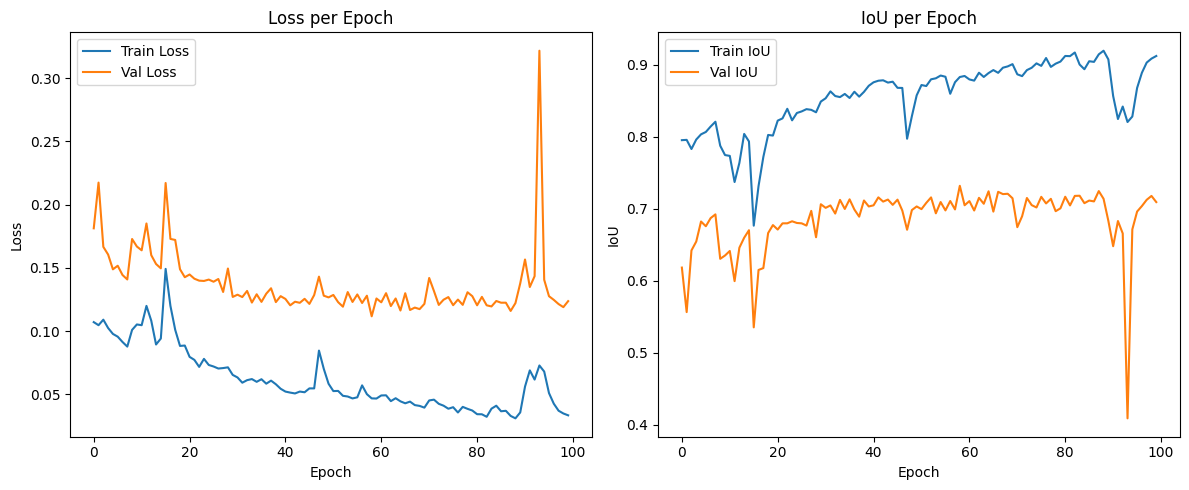

In [11]:
# ==================================================
# 6. train & validate 함수
# ==================================================
def train_epoch(model, dataloader, optimizer, device=DEVICE):
    """한 에폭 학습"""
    model.train()
    epoch_loss = 0
    epoch_iou = 0
    total_batches = 0

    for i, (imgs, masks) in enumerate(dataloader):
        imgs = imgs.to(device)
        masks = masks.to(device)

        # 순전파
        preds = model(imgs)
        loss = combined_loss(preds, masks)

        # 역전파
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # 메트릭 업데이트
        epoch_loss += loss.item()
        epoch_iou += iou_score(preds, masks).item()
        total_batches += 1

        # 진행상황 출력
        if (i + 1) % PRINT_FREQ == 0:
            print(f"Batch {i+1}/{len(dataloader)} - Loss: {loss.item():.4f}")

    return epoch_loss / total_batches, epoch_iou / total_batches


def validate(model, dataloader, device=DEVICE):
    """검증 데이터에 대한 평가"""
    model.eval()
    val_loss = 0
    val_iou = 0
    total_batches = 0

    with torch.no_grad():
        for imgs, masks in dataloader:
            imgs = imgs.to(device)
            masks = masks.to(device)

            # 순전파
            preds = model(imgs)
            loss = combined_loss(preds, masks)

            # 메트릭 업데이트
            val_loss += loss.item()
            val_iou += iou_score(preds, masks).item()
            total_batches += 1

    return val_loss / total_batches, val_iou / total_batches


# 학습 실행
best_iou = 0
history = {'train_loss': [], 'train_iou': [], 'val_loss': [], 'val_iou': []}

for epoch in range(1, EPOCHS + 1):
    start_time = time.time()

    # 학습
    train_loss, train_iou = train_epoch(model, train_loader, optimizer)

    # 검증
    val_loss, val_iou = validate(model, val_loader)

    # 히스토리 업데이트
    history['train_loss'].append(train_loss)
    history['train_iou'].append(train_iou)
    history['val_loss'].append(val_loss)
    history['val_iou'].append(val_iou)

    # 모델 저장
    if val_iou > best_iou:
        best_iou = val_iou
        torch.save(model.state_dict(), best_path)
        print(f"✓ 모델 저장됨: {best_path} (IoU: {best_iou:.4f})")

    # 에폭 결과 출력
    epoch_time = time.time() - start_time
    print(f"Epoch {epoch}/{EPOCHS} - {epoch_time:.1f}s - "
          f"Train Loss: {train_loss:.4f}, Train IoU: {train_iou:.4f}, "
          f"Val Loss: {val_loss:.4f}, Val IoU: {val_iou:.4f}")

# 학습 결과 시각화
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Val Loss')
plt.title('Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history['train_iou'], label='Train IoU')
plt.plot(history['val_iou'], label='Val IoU')
plt.title('IoU per Epoch')
plt.xlabel('Epoch')
plt.ylabel('IoU')
plt.legend()
plt.tight_layout()
plt.show()

In [12]:
# ==================================================
# ★ 세그멘테이션 오버레이 시각화 (배치 크기 무관)
# ==================================================

@torch.no_grad()
def visualize_overlay(model, loader, device=DEVICE, n=6, alpha=0.45):
    """
    • 원본 이미지 위에 GT(녹색) · 예측(빨간색) 마스크를 반투명 오버레이
    • n 장이 확보될 때까지 DataLoader에서 연속적으로 가져옴
    • 최대 4장씩 가로로 배치
    """
    model.eval()

    # ---------- n장 모으기 ----------
    imgs_acc, masks_acc, preds_acc = [], [], []
    for imgs, masks in loader:
        imgs_acc.append(imgs)
        masks_acc.append(masks)
        preds_acc.append((torch.sigmoid(model(imgs.to(device))) > 0.5).cpu())
        if sum(b.size(0) for b in imgs_acc) >= n:
            break

    imgs  = torch.cat(imgs_acc)[:n]   # (n,3,H,W)
    masks = torch.cat(masks_acc)[:n]  # (n,1,H,W)
    preds = torch.cat(preds_acc)[:n]  # (n,1,H,W)

    # ---------- 오버레이 ----------
    gt_color   = np.array([0, 1, 0])   # green
    pred_color = np.array([1, 0, 0])   # red

    cols = 4
    rows = math.ceil(n / cols)
    fig, axes = plt.subplots(rows, cols, figsize=(cols * 4, rows * 4))
    axes = axes.flatten()        # 2D → 1D 배열로 편하게 인덱싱

    for i in range(n):
        img_np = imgs[i].permute(1, 2, 0).numpy()
        gt_np  = masks[i, 0].numpy()
        pr_np  = preds[i, 0].numpy()

        overlay = img_np.copy()
        overlay[gt_np == 1] = (1 - alpha) * overlay[gt_np == 1] + alpha * gt_color
        overlay[pr_np == 1] = (1 - alpha) * overlay[pr_np == 1] + alpha * pred_color

        axes[i].imshow(overlay)
        axes[i].axis("off")
        axes[i].set_title(f"Sample {i}")

    # 남는 서브플롯은 비우기
    for j in range(n, rows * cols):
        axes[j].axis("off")

    # 범례
    green_patch = mpatches.Patch(color="green", label="Ground Truth")
    red_patch   = mpatches.Patch(color="red",   label="Prediction")
    plt.legend(handles=[green_patch, red_patch],
               bbox_to_anchor=(1.05, 1), loc="upper left")

    plt.tight_layout()
    plt.show()

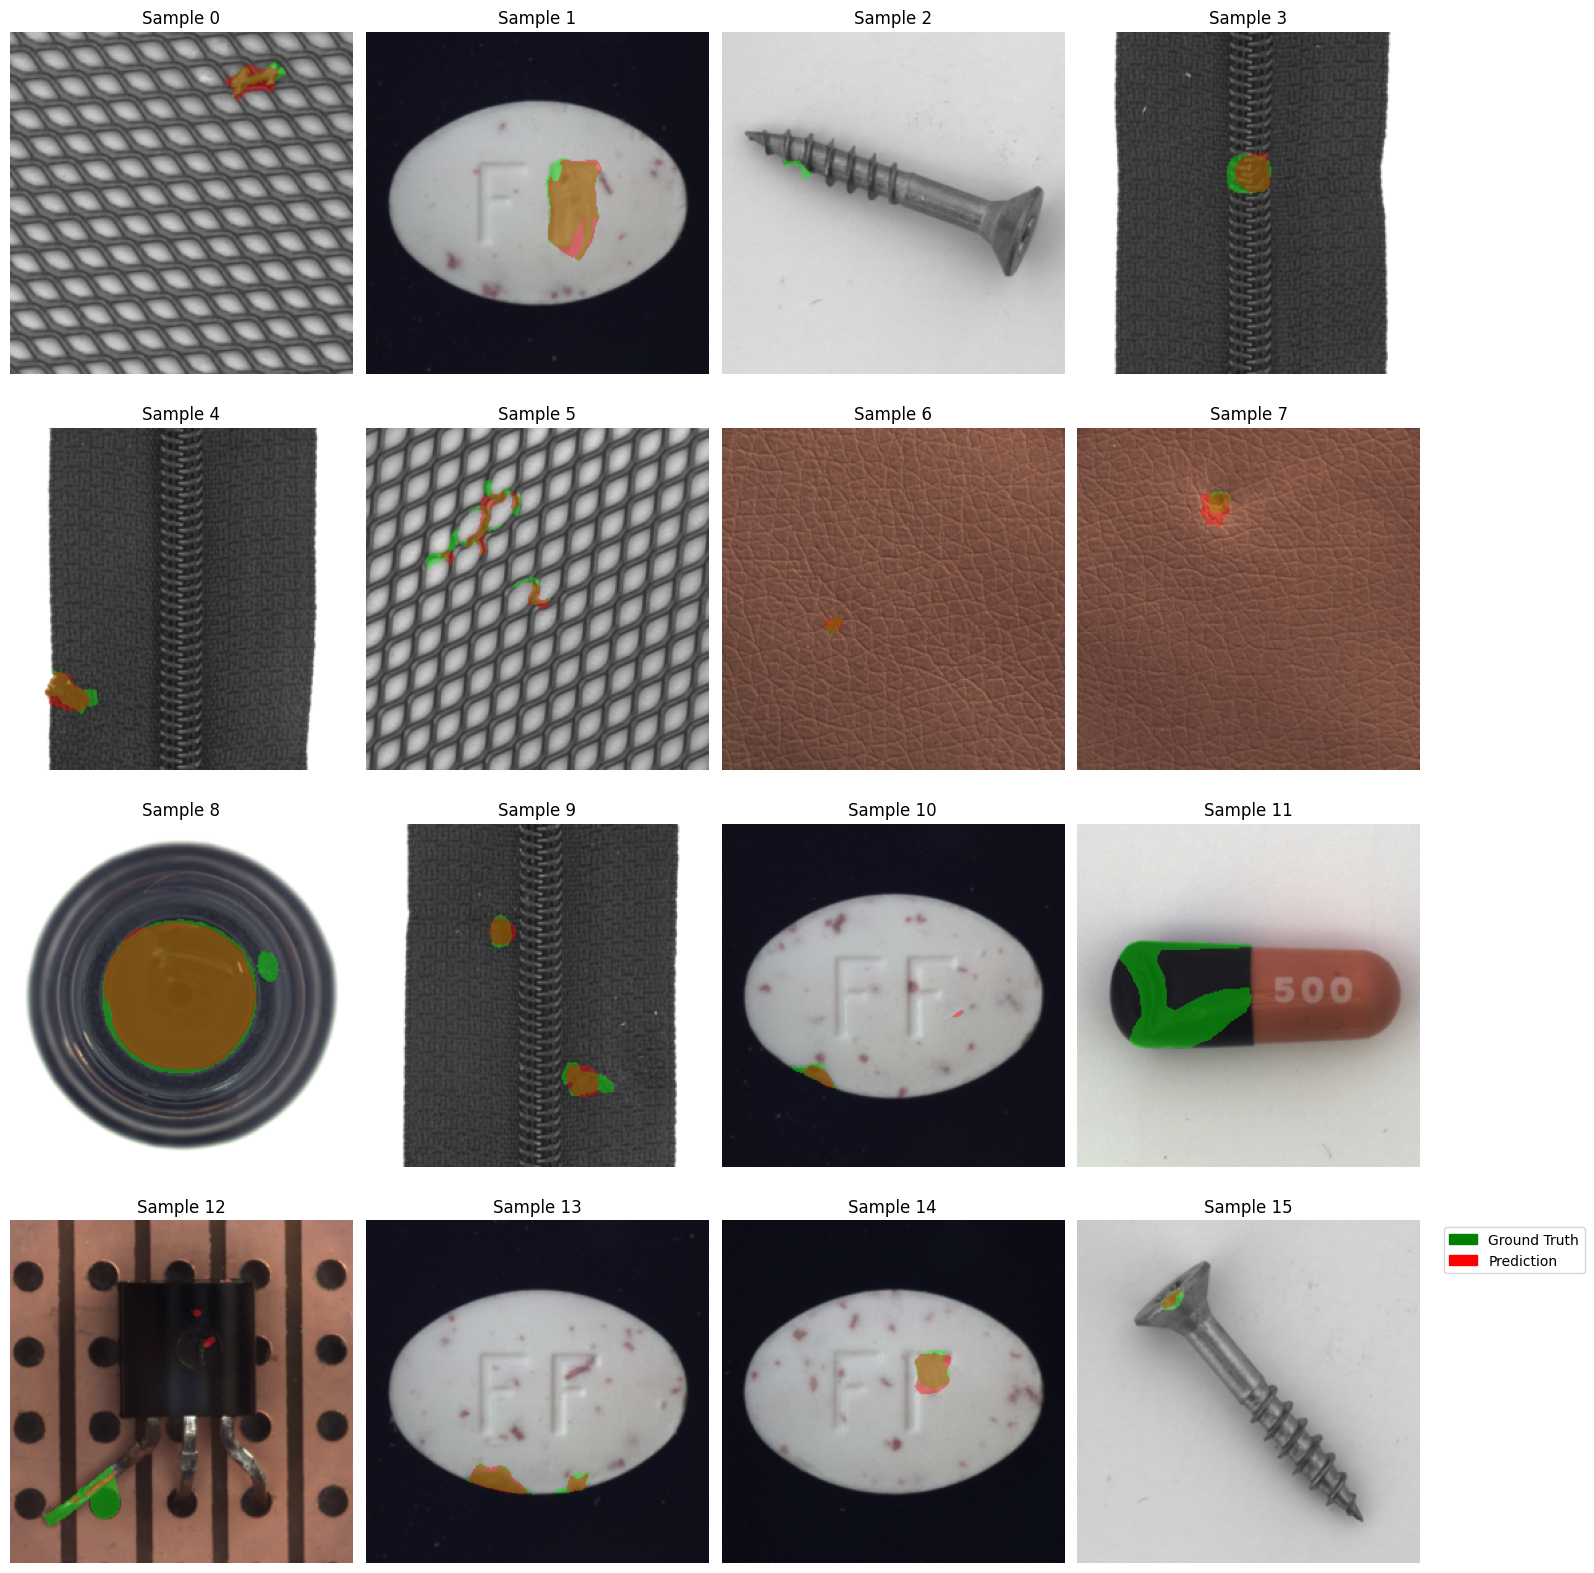

In [13]:
# Best 모델 로드 후 오버레이 시각화
model.load_state_dict(torch.load(best_path, map_location=DEVICE))
visualize_overlay(model, val_loader, n=16, alpha=0.4)